<a href="https://colab.research.google.com/github/AadeshVarude/Structure-from-Motion-and-NERF/blob/main/Tiny_nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from typing import Optional

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
class tiny_nerf_model(torch.nn.Module):
  def __init__(self,filter_size=128,num_encoding_functions=6):
    super(tiny_nerf_model,self).__init__()
    self.layer1=torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    self.layer2=torch.nn.Linear(filter_size, filter_size)
    self.layer3=torch.nn.Linear(filter_size, 4)
  def forward(self,x):
    x=torch.nn.functional.relu(self.layer1(x))
    x=torch.nn.functional.relu(self.layer2(x))
    x=self.layer3(x)
    return x


# Defining functions related to rays

In [4]:
def get_rays(height: int, width: int, focal: float,cam_pose: torch.Tensor):
  i,j=torch.meshgrid(torch.arange(width).to(cam_pose),torch.arange(height).to(cam_pose))
  i,j=i.transpose(-1,-2),j.transpose(-1,-2)
  directions=torch.stack([(i - width * .5) / focal,
                            -(j - height * .5) / focal,
                            -torch.ones_like(i)
                           ], dim=-1)
  camera_dirs=directions[..., None, :]*cam_pose[:3,:3]
  ray_dirs=torch.sum(directions[..., None, :] * cam_pose[:3, :3], dim=-1)
  ray_origins=cam_pose[:3,-1].expand(ray_dirs.shape)
  print('ray_dirs.shape',ray_dirs.shape)
  return ray_origins,ray_dirs

def get_flat_rays(ray_origins: torch.Tensor,ray_dirs: torch.Tensor,near: float,far: float,num_samples: int, rand= True) -> (torch.Tensor, torch.Tensor):
  t_vals=torch.linspace(near,far,num_samples).to(ray_origins)
  if rand is True:
    noise_shape=list(ray_origins.shape[:-1])+[num_samples]
    noise=torch.rand(noise_shape).to(ray_origins)*(far-near)/num_samples
    t_vals=t_vals+noise
  flat_rays = ray_origins[..., None, :] + ray_dirs[..., None, :] * t_vals[..., :, None]
  return flat_rays,t_vals



#Rendering the volume density (RGB AND SIGMA CALCULATION)

In [5]:
def vol_density(radience: torch.Tensor,ray_origins: torch.Tensor,t_vals: torch.Tensor):
  sigma=F.relu(radience[...,3])
  rgb=torch.sigmoid(radience[...,:3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((t_vals[..., 1:] - t_vals[..., :-1],one_e_10.expand(t_vals[..., :1].shape)), dim=-1)
  # print(dists.shape)
  # print(sigma.shape)
  alpha = 1. - torch.exp(-sigma * dists)
  cumprod=torch.cumprod(1. - alpha + 1e-10,-1)
  cumprod=torch.roll(cumprod,1,-1)
  cumprod[..., 0] = 1.
  weights = alpha * cumprod
  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * t_vals).sum(dim=-1)
  acc_map = weights.sum(-1)
  return rgb_map,depth_map, acc_map

In [6]:
def pose_encode(tensor, num_encoding_functions=6, include_input=True, log_sampling=True) -> torch.Tensor:
  position=[tensor] if include_input else []
  frequency_bands = None
  if log_sampling:
    frequency_bands = 2.0 ** torch.linspace(0.0,num_encoding_functions - 1,
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )
  else:
    frequency_bands = torch.linspace(
        2.0 ** 0.0,
        2.0 ** (num_encoding_functions - 1),
        num_encoding_functions,
        dtype=tensor.dtype,
        device=tensor.device,
    )
  for freq in frequency_bands:
    for func in [torch.sin, torch.cos]:
      position.append(func(tensor * freq))
  if len(position)==1:
    return position[0]
  else:
    return torch.cat(position,dim=-1)


In [7]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2022-12-26 15:40:08--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bmild.com/nerf/tiny_nerf_data.npz [following]
--2022-12-26 15:40:09--  https://bmild.com/nerf/tiny_nerf_data.npz
Resolving bmild.com (bmild.com)... 216.239.32.21, 216.239.38.21, 216.239.34.21, ...
Connecting to bmild.com (bmild.com)|216.239.32.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bmild.github.io/nerf/tiny_nerf_data.npz [following]
--2022-12-26 15:40:09--  https://bmild.github.io/nerf/tiny_nerf_data.npz
Resolving bmild.github.io (bmild.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to bmild.github.io (bmild.github.io)|185.199.110.153|:443... connected.
HTTP re

In [12]:
def run_tinynerf(heigth,width,focal,cam_pose,near,far,depth_samples_per_ray,encoding_func, get_minibatches_function):
  ray_origins,ray_dirs=get_rays(height, width, focal,cam_pose)
  flat_rays,t_vals=get_flat_rays(ray_origins,ray_dirs,near,far,depth_samples_per_ray)

  qflat_rays=flat_rays.reshape((-1,3))
  encoded_points=encoding_func(qflat_rays)
  batches=get_minibatches_function(encoded_points,chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(flat_rays.shape[:-1]) + [4]
  
  # print("unflaten,shape",unflattened_shape)
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = vol_density(radiance_field, ray_origins, t_vals)

  return rgb_predicted




In [16]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[52], tform_cam2world[52]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
Loss: 0.15842467546463013


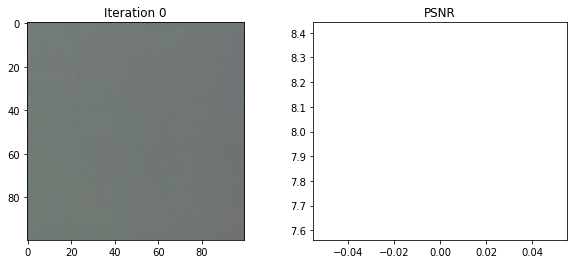

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

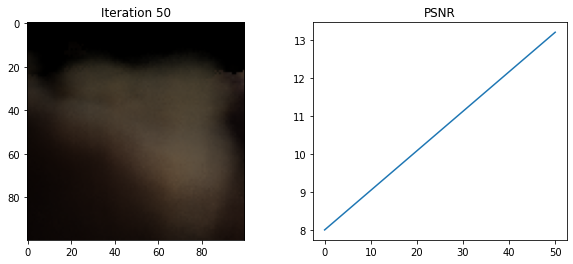

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

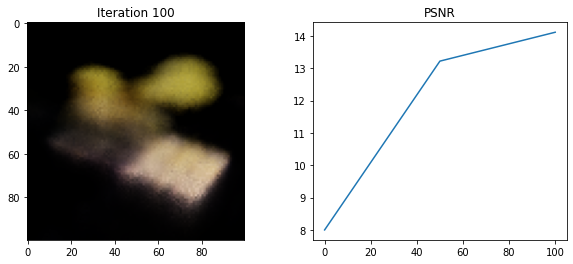

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

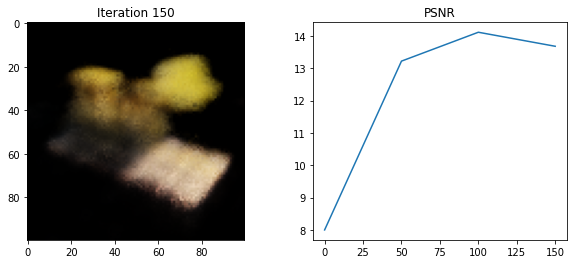

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

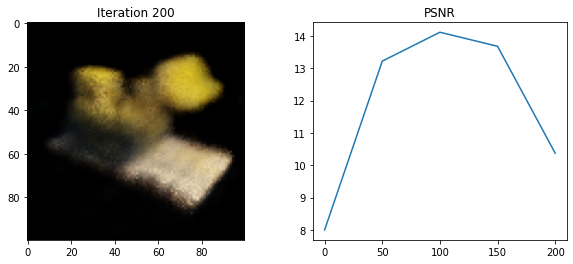

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

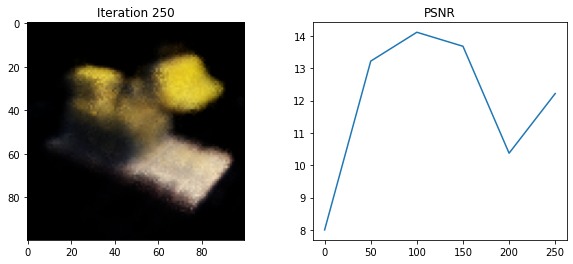

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

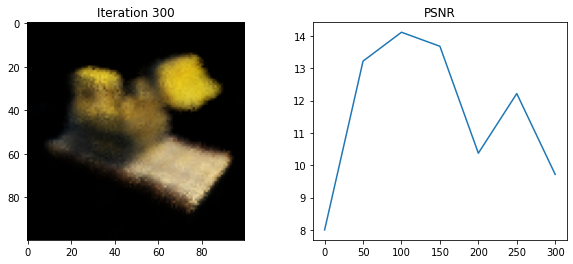

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

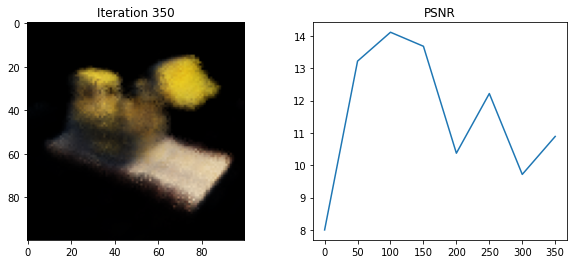

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

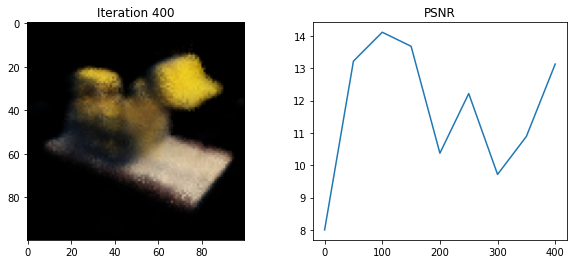

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

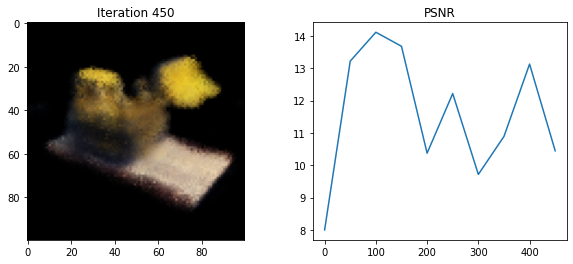

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

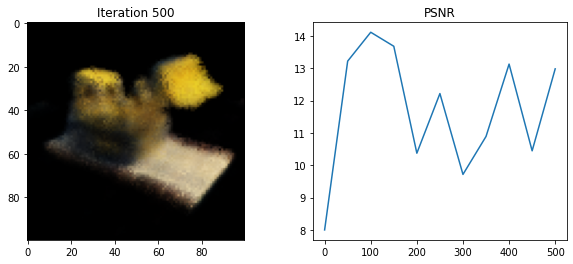

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

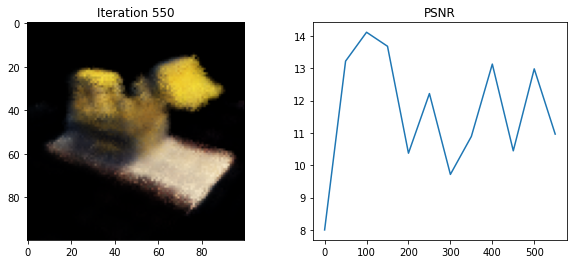

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

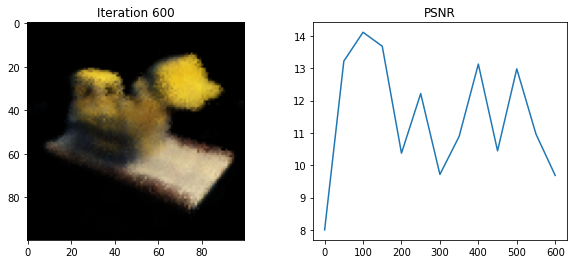

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

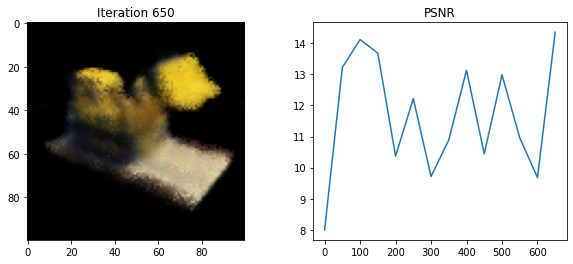

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

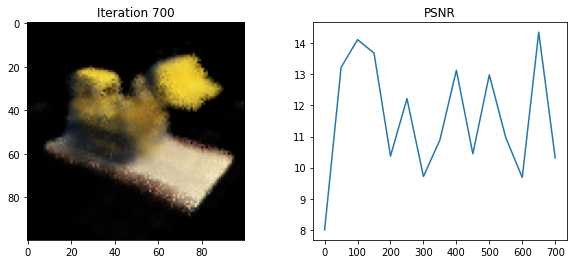

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

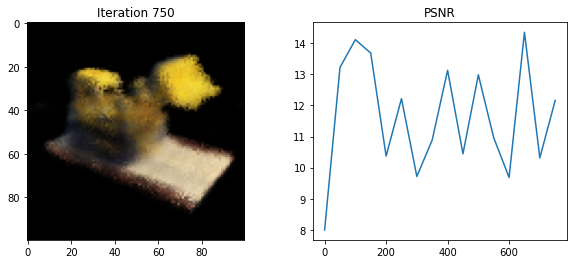

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

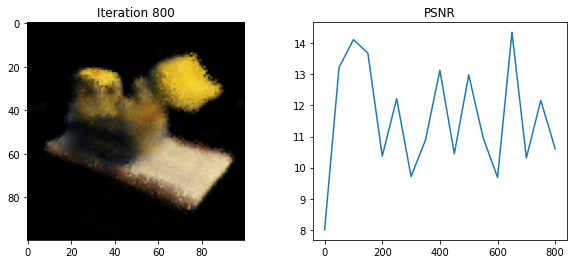

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

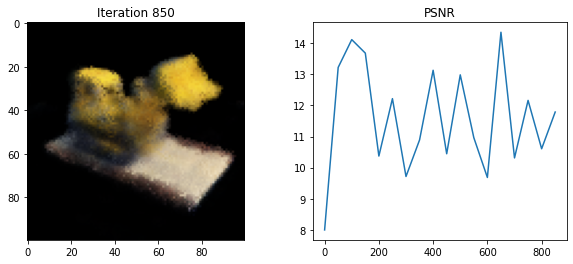

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

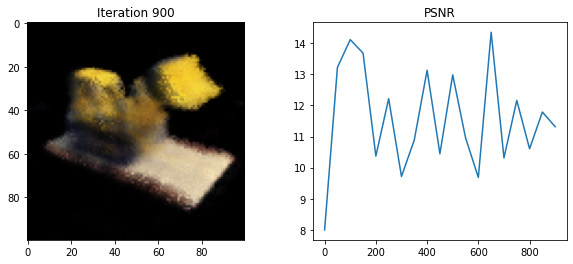

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

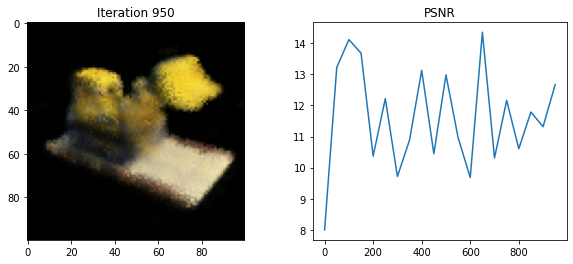

ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
torch.Size([100, 100, 32])
ray_dirs.shape torch.Size([100, 100, 3])
unflaten,shape [100, 100, 32, 4]
torch.Size([100, 100, 32])
tor

In [17]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: pose_encode(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 1000

# Misc parameters
display_every = 50  # Number of iters after which stats are displayed

"""
Model
"""
model = tiny_nerf_model(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_tinynerf(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  # print("maxrgb_pred",rgb_predicted.max())

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_tinynerf(height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)
    
    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')